# Pasikliautiniai intervalai su Python

Šiame užraše pateikiami pasikliautinių intervalų skaičiavimo pavyzdžiai naudojant Python. 
Pateikiami dažniausi praktiniai atvejai:
- pasikliautinis intervalas vidurkiui (t skirstinys),
- pasikliautinis intervalas proporcijai (Z aproksimacija),
- pagrindinis pasikliautinio intervalo interpretavimas,
- gerosios praktikos ir dažniausios klaidos.

Pasikliautinis intervalas yra būdas įvertinti neapibrėžtumą aplink imties įvertį.


## 1. Importai ir aplinka

Naudojamos bibliotekos:
- `numpy` – baziniams skaičiavimams,
- `pandas` – duomenų tvarkymui,
- `scipy.stats` – kritinėms reikšmėms ir pasikliautiniams intervalams,
- `matplotlib` – vizualizacijoms.

Pastaba: pavyzdžiuose naudojama fiksuota atsitiktinių skaičių sėkla, kad rezultatai būtų atkartojami.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

np.random.seed(42)


## 2. Pavyzdiniai duomenys

Sugeneruojamas paprastas duomenų rinkinys, kuris gali priminti matavimo rezultatus arba pardavimų reikšmes.
Toliau skaičiuojamas imties vidurkis ir jo pasikliautinis intervalas.


In [2]:
n = 30
data = np.random.normal(loc=100, scale=15, size=n)  # pavyzdžiui: pardavimų lygis su svyravimais
s = pd.Series(data, name="sales")

s.head(), s.describe()


(0    107.450712
 1     97.926035
 2    109.715328
 3    122.845448
 4     96.487699
 Name: sales, dtype: float64,
 count     30.000000
 mean      97.177797
 std       13.500096
 min       71.300796
 25%       91.134237
 50%       96.487823
 75%      105.405030
 max      123.688192
 Name: sales, dtype: float64)

In [4]:
s.describe().T

count     30.000000
mean      97.177797
std       13.500096
min       71.300796
25%       91.134237
50%       96.487823
75%      105.405030
max      123.688192
Name: sales, dtype: float64

## 3. Pasikliautinis intervalas vidurkiui (t skirstinys)

Dažniausias realus atvejis: populiacijos dispersija nežinoma, todėl naudojamas Studento t skirstinys.

Bendra forma:
- `x̄` – imties vidurkis,
- `SE = s / √n` – standartinė paklaida,
- `t*` – kritinė reikšmė pagal pasirinktą pasikliautinumo lygį ir `df = n-1`.

Formulė:
`PI = x̄ ± t* × SE`


In [3]:
mean = s.mean()
std = s.std(ddof=1)  # imties standartinis nuokrypis
n = s.size
se = std / np.sqrt(n)

confidence = 0.95
df = n - 1
t_crit = stats.t.ppf((1 + confidence) / 2, df=df)

ci_low = mean - t_crit * se
ci_high = mean + t_crit * se

mean, se, t_crit, (ci_low, ci_high)


(97.17779656223442,
 2.464769110939682,
 2.045229642132703,
 (92.13677771552751, 102.21881540894132))

### Interpretacija

- Intervalo centras yra imties vidurkis.
- Intervalo plotį lemia duomenų sklaida (`s`), imties dydis (`n`) ir pasirinktas pasikliautinumo lygis.
- Didėjant `n`, intervalas siaurėja, nes mažėja standartinė paklaida.

Imties vidurkis = 97.18  
Standartinė paklaida (SE) = 2.46  
t kritinė reikšmė (95 % pasikliovimo lygis) = 2.05  

95 % pasikliautinis intervalas:
(92.14 ; 102.22)

Tai reiškia, kad remiantis turima imtimi, tikrasis populiacijos vidurkis su 95 % pasikliovimo tikimybe patenka į intervalą nuo 92.14 iki 102.22.

Standartinė paklaida rodo, kiek imties vidurkis gali svyruoti dėl atsitiktinės atrankos. t kritinė reikšmė naudojama todėl, kad populiacijos dispersija nežinoma ir naudojamas imties standartinis nuokrypis.

Jei tyrimą kartotume daug kartų, apie 95 % tokių intervalų apimtų tikrąjį populiacijos vidurkį.



## 4. Tas pats skaičiavimas su `scipy.stats`

`scipy.stats` leidžia pasikliautinį intervalą apskaičiuoti tiesiogiai, sumažinant rankinių klaidų tikimybę.


In [5]:
ci = stats.t.interval(
    confidence=confidence,
    df=df,
    loc=mean,
    scale=se
)
ci


(92.13677771552751, 102.21881540894132)

Naudojant scipy.stats gautas 95 % pasikliautinis intervalas:

(92.14 ; 102.22)

Tai reiškia, kad tikrasis populiacijos vidurkis, su 95 % pasikliovimo tikimybe, yra tarp 92.14 ir 102.22.

Intervalas sutampa su rankiniu skaičiavimu, nes abu metodai remiasi ta pačia formule:
vidurkis ± t_kritinė_reikšmė × standartinė_paklaida.

Interpretacija išlieka ta pati: jei imtis būtų kartojama daug kartų, apie 95 % tokių intervalų apimtų tikrąjį populiacijos vidurkį.


## 5. Pasikliautinis intervalas proporcijai (Z aproksimacija)

Kai nagrinėjama kategorinė baigtis (pvz., „teigiamas / neigiamas“ atsakymas), dažnai domina proporcija `p̂`.

Klasikinė (Wald) forma:
`p̂ ± z* × √( p̂(1-p̂) / n )`

Kur:
- `p̂` – imties proporcija,
- `z*` – kritinė reikšmė iš standartinio normaliojo skirstinio.

Pastaba: ši aproksimacija prasčiau veikia, kai imtis maža arba proporcija labai arti 0 ar 1.


In [8]:
# Pavyzdys: 80 respondentų, 52 teigiami įvertinimai
n = 80
success = 52
p_hat = success / n

confidence = 0.95
z_crit = stats.norm.ppf((1 + confidence) / 2)

se_p = np.sqrt(p_hat * (1 - p_hat) / n)
ci_low = p_hat - z_crit * se_p
ci_high = p_hat + z_crit * se_p

p_hat, z_crit, (ci_low, ci_high)


(0.65, 1.959963984540054, (0.545481348452303, 0.754518651547697))

Imties proporcija (p̂) = 0.65 → 65 % respondentų pateikė teigiamą įvertinimą.  

Naudota 95 % pasikliovimo reikšmė, todėl z kritinė reikšmė ≈ 1.96.

95 % pasikliautinis intervalas proporcijai:
(0.545 ; 0.755)

Tai reiškia, kad tikroji populiacijos teigiamų įvertinimų dalis, su 95 % pasikliovimo tikimybe, yra tarp 54.5 % ir 75.5 %.

Interpretacija: nors imtyje gauta 65 %, dėl atsitiktinės atrankos tikrasis rodiklis gali būti maždaug ±10 procentinių punktų ribose.


### Interpretacija (proporcija)

- `p̂` yra taškinis proporcijos įvertis iš imties.
- Intervalas parodo neapibrėžtumą dėl atsitiktinės atrankos.
- Didėjant `n`, intervalas siaurėja.


## 6. Vizualus pasikliautinio intervalo vaizdavimas

Vizualizacija padeda suprasti intervalo centrą ir plotį. Toliau pavaizduojamas imties vidurkis ir jo 95 % pasikliautinis intervalas.


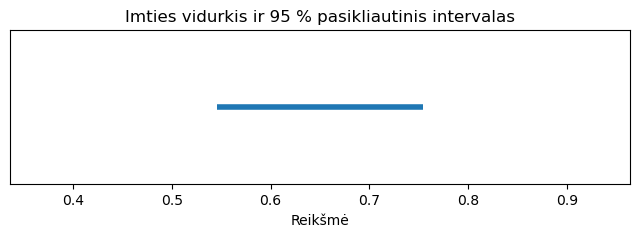

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))

# 95 % pasikliautinis intervalas
plt.hlines(0, ci_low, ci_high, linewidth=4)

# vidurkis
plt.plot(mean, 0, 'o', markersize=8)

plt.yticks([])
plt.ylim(-0.5, 0.5)
plt.xlim(ci_low - (ci_high - ci_low),
         ci_high + (ci_high - ci_low))

plt.title("Imties vidurkis ir 95 % pasikliautinis intervalas")
plt.xlabel("Reikšmė")
plt.show()

Grafike pavaizduotas imties vidurkis ir jo 95 % pasikliautinis intervalas.

Horizontali linija žymi 95 % intervalą nuo ci_low iki ci_high. Ji rodo, kokiame reikšmių intervale su 95 % pasikliovimo tikimybe yra tikrasis populiacijos parametras.

Taškas linijos centre žymi imties vidurkį (mean). Tai geriausias populiacijos vidurkio įvertis pagal turimus duomenis.

Kuo intervalas trumpesnis, tuo įvertis tikslesnis (mažesnė standartinė paklaida). Kuo intervalas ilgesnis, tuo didesnis neapibrėžtumas.

Interpretacija: tikėtina, kad tikrasis populiacijos vidurkis patenka į pavaizduotą intervalą.


## 7. Gerosios praktikos

- Nurodyti pasikliautinumo lygį (pvz., 95 %), imties dydį `n` ir rodiklį, kuriam intervalas apskaičiuotas.
- Prieš skaičiuojant įvertinti duomenų kokybę: trūkstamas reikšmes, išskirtis, matavimo klaidas.
- Vidurkiui dažniausiai naudoti t skirstinį, nes populiacijos dispersija beveik niekada nėra žinoma.
- Proporcijoms, kai imtis maža arba proporcija arti 0 ar 1, svarstyti tikslesnius metodus (pvz., Wilson), o ne vien Wald aproksimaciją.


## 8. Dažniausios klaidos

- 95 % pasikliautinis intervalas interpretuojamas kaip 95 % tikimybė, kad parametras yra konkrečiame intervale.
- Naudojamas Z, kai imtis maža ir populiacijos dispersija nežinoma (vidurkiui tinkamesnis t skirstinys).
- Intervalas pateikiamas be konteksto: nenurodoma, ką jis apima ir koks yra `n`.
- Skaičiuojami intervalai techniniams identifikatoriams (Id), kurių statistinė prasmė nėra analitinė.
- Ignoruojamas imties šališkumas: nereprezentatyvi imtis duos klaidinančius intervalus.


## 9. Trumpa santrauka

- Vidurkio PI: `x̄ ± t* × SE`, kur `SE = s/√n`.
- Proporcijos PI: `p̂ ± z* × SE`, kur `SE = √(p̂(1-p̂)/n)`.
- Intervalo plotis mažėja didėjant imčiai ir mažėjant sklaidai.
- Prasmė atsiranda tik tada, kai analizuojamas prasmingas rodiklis ir imtis yra reprezentatyvi.
